# Check sync process

In [107]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [108]:
import datetime
import pathlib
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal as sp


from u19_pipeline.ephys_pipeline import ephys_element, probe_element, get_session_directory, get_ephys_root_data_dir
import u19_pipeline.utils.ephys_fix_sync_code as ephys_fix_sync_code
import u19_pipeline.acquisition as acquisition
import datajoint as dj

from element_interface.utils import find_full_path

import u19_pipeline.utils.DemoReadSGLXData.readSGLX as readSGLX
import u19_pipeline.utils.ephys_utils as ephys_utils


In [109]:
recording_query = "recording_id = 513"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_key = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


key = (recording.Recording.BehaviorSession & recording_query).fetch1()
del key['recording_id']

key

{'subject_fullname': 'jk8386_jknpx6',
 'session_date': datetime.date(2025, 11, 12),
 'session_number': 0}

In [110]:
session_dir = pathlib.Path(get_session_directory(recording_key[0]))
session_dir


PosixPath('jk8386/jk8386_jknpx6/20251112_g0/jknpx6_20251211_g0')

In [111]:
session_dir = find_full_path(get_ephys_root_data_dir(),
                            get_session_directory(recording_key))
print(session_dir)
#session_dir = pathlib.Path('/Users/alvaros/Documents/MATLAB/BrainCogsProjects/CalciumImagingData/test_g0/')
#Check if session is Nidq or OneBox
nidq_session = list(session_dir.glob('*nidq.bin*'))
obx_session = list(session_dir.glob('*obx.bin*'))

if len(nidq_session) == 0 and len(obx_session) == 0:
    print('No session found')
elif len(nidq_session) > 0:
    ephys_session_fullpath = nidq_session[0]
else:
    ephys_session_fullpath = obx_session[0]

#Nidaq file
nidq_meta          = readSGLX.readMeta(ephys_session_fullpath)
nidq_sampling_rate = readSGLX.SampRate(nidq_meta)


# 1: load meta data, and the content of the NIDAQ file. Its content is digital.            
new_trial_channel = 1
new_iteration_channel = 2
# If PXIe card (nidq) card use for recording deduce digital channels
if nidq_meta['typeThis'] == 'nidq':
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta)
# If onebox card (obx) card use for recording digital channels are 0-2
else:
    digital_array      = ephys_utils.spice_glx_utility.load_spice_glx_digital_file(ephys_session_fullpath, nidq_meta, d_line_list=[0,1])
    # If no sync pulse found trial and iteration signals are 0 & 1 respectively
    channel0_pulses = np.where(np.diff(digital_array[0])==1)[0].shape[0]
    channel1_pulses = np.where(np.diff(digital_array[1])==1)[0].shape[0]

    if channel0_pulses > channel1_pulses:
        new_trial_channel = 1
        new_iteration_channel = 0
    else:
        new_trial_channel = 0
        new_iteration_channel = 1

/mnt/cup/braininit/Data/Raw/electrophysiology/jk8386/jk8386_jknpx6/20251112_g0/jknpx6_20251211_g0
['0', '7']
nChan: 1, nFileSamp: 17989515


# Synchronize ePhys and Behavior

Populate the tables, using the nidaq file produced by spikeGLX. This is done automatically and produces a record of VR iteration numbers measured in the time of the ePhys setup.

### Read nidaq file and behavior data

In [112]:
#Behavior data
behavior_key = key.copy()
behavior = dj.create_virtual_module('behavior', 'u19_behavior')

block = 0
# If a specific block is requested, add that to our behavior_key. It should be an int referring to virmen block number.
# This is useful for sessions in which the nidaq stream was interrupted due to restarting virmen
if block > 0:
    behavior_key['block'] = block

thissession = behavior.TowersBlock().Trial() & behavior_key
behavior_time, beh_num_iterations, trial_start_time = thissession.fetch('trial_time', 'iterations', 'trial_abs_start')

session_datetimes = (acquisition.Session() & behavior_key).fetch('session_start_time', 'session_end_time')
seconds_end = (session_datetimes[1][0]- session_datetimes[0][0]).seconds

last_iter_last_trial = seconds_end - trial_start_time[-1]
last_iter_last_trial

np.float64(34.42000000000007)

In [113]:
'''
new_behavior_trial_times = []
for idx_trial in range(behavior_time.shape[0]):

    if idx_trial < behavior_time.shape[0]-1:
        new_behavior_trial_times.append(np.append(behavior_time[idx_trial].squeeze()[1:], trial_start_time[idx_trial+1]-trial_start_time[idx_trial]-behavior_time[idx_trial][1]))
    else:
        print(behavior_time[idx_trial].squeeze()[-1])
        new_behavior_trial_times.append(np.append(behavior_time[idx_trial].squeeze()[1:], last_iter_last_trial))

behavior_time = np.asarray(new_behavior_trial_times, dtype=object)
'''


'\nnew_behavior_trial_times = []\nfor idx_trial in range(behavior_time.shape[0]):\n\n    if idx_trial < behavior_time.shape[0]-1:\n        new_behavior_trial_times.append(np.append(behavior_time[idx_trial].squeeze()[1:], trial_start_time[idx_trial+1]-trial_start_time[idx_trial]-behavior_time[idx_trial][1]))\n    else:\n        print(behavior_time[idx_trial].squeeze()[-1])\n        new_behavior_trial_times.append(np.append(behavior_time[idx_trial].squeeze()[1:], last_iter_last_trial))\n\nbehavior_time = np.asarray(new_behavior_trial_times, dtype=object)\n'

In [114]:
#plt.plot(np.diff(digital_array[new_trial_channel,:5000000]))
#plt.plot(digital_array[new_trial_channel,:5000000])


### Get samples and times where trials and iterations start

In [115]:
mode = None   #Default for sessions before 12/01/2021
#mode = 'pulses'    #Default for sessions after 12/01/2021
iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(digital_array[new_trial_channel,:], digital_array[new_iteration_channel,:], nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode=mode)
#                             get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal,


# Check # of trials and iterations match
trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

print(trial_count_diff)
print(trials_diff_iteration_big)
print(trials_diff_iteration_small)


status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])


len trial_start_idx (346,)
mode deduction:  counter_bit0
0
[]
[]
Synced perfectly xxxxxxxxxxxxxx


In [126]:
trial_fix = 36
synced_iteration_vector = iteration_dict['iter_start_idx'][trial_fix]
synced_time_vector = (iteration_dict['iter_times_idx'][trial_fix]).copy()

behavior_time_vector = behavior_time[trial_fix].flatten()

synced_time_vector += behavior_time_vector[1]
old_synced_time_vector = (synced_time_vector).copy()

print(old_synced_time_vector[0:5])
print(behavior_time_vector[0:5])
print('--------------------')
print(np.diff(old_synced_time_vector[0:6]))
print(np.diff(behavior_time_vector[0:6]))
print(iteration_dict['iter_times_idx'][trial_fix][0:5])

[0.0513349  0.05773482 0.06773469 0.07333462 0.07793457]
[0.        0.0513349 0.0583702 0.0686514 0.0737321]
--------------------
[0.00639992 0.00999987 0.00559993 0.00459994 0.00879989]
[0.0513349 0.0070353 0.0102812 0.0050807 0.007868 ]
[0.         0.00639992 0.01639979 0.02199972 0.02659967]


In [127]:
behavior_time_vector.shape

(922,)

In [128]:

'''
#synced_time_vector = synced_time_vector+behavior_time_vector[1]-(behavior_time_vector[2]-synced_time_vector[2])
synced_time_vector = synced_time_vector+behavior_time_vector[1]
synced_time_vector = np.insert(synced_time_vector, 1, behavior_time_vector[1])
synced_time_vector[2:] = synced_time_vector[2:]+(behavior_time_vector[2]-synced_time_vector[2])
synced_time_vector[0] = 0

if synced_time_vector.shape[0] > behavior_time_vector.shape[0]:
    synced_time_vector = synced_time_vector[:-1]


print(synced_time_vector[0:5])
print(behavior_time_vector[0:5])
'''

'\n#synced_time_vector = synced_time_vector+behavior_time_vector[1]-(behavior_time_vector[2]-synced_time_vector[2])\nsynced_time_vector = synced_time_vector+behavior_time_vector[1]\nsynced_time_vector = np.insert(synced_time_vector, 1, behavior_time_vector[1])\nsynced_time_vector[2:] = synced_time_vector[2:]+(behavior_time_vector[2]-synced_time_vector[2])\nsynced_time_vector[0] = 0\n\nif synced_time_vector.shape[0] > behavior_time_vector.shape[0]:\n    synced_time_vector = synced_time_vector[:-1]\n\n\nprint(synced_time_vector[0:5])\nprint(behavior_time_vector[0:5])\n'

[np.float64(-0.002236363591004647), np.float64(0.004763636408995353), np.float64(0.011763636408995352)]


Text(0.5, 1.0, 'Before & After applying (get_shift_vector))')

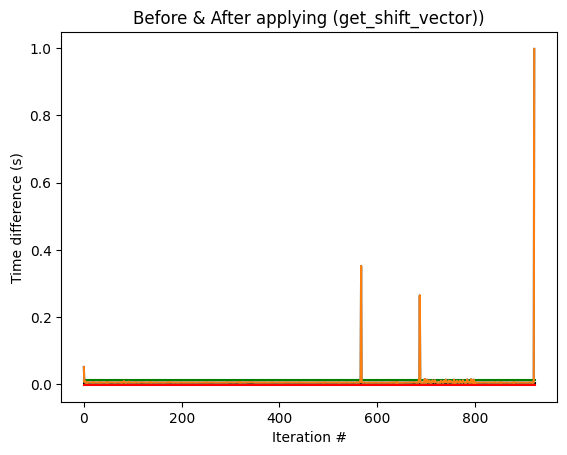

In [129]:

synced_time_vector2, shift_vec, median_vec = ephys_fix_sync_code.get_shift_vector(synced_time_vector,behavior_time_vector)

print(median_vec)



#median_diff = np.median(baseline_diff)
#max_diff = np.median(baseline_diff)+0.007
#min_diff = np.median(baseline_diff)-0.007
#time_vec = np.arange(base_size-initial_sample)
plt.plot([0, synced_time_vector.shape[0]], [median_vec[1], median_vec[1]],'k')
plt.plot([0, synced_time_vector.shape[0]], [median_vec[0], median_vec[0]],'r')
plt.plot([0, synced_time_vector.shape[0]], [median_vec[2], median_vec[2]],'g')

plt.plot(synced_time_vector - behavior_time_vector[:synced_time_vector.shape[0]])
plt.plot(synced_time_vector2 - behavior_time_vector[:synced_time_vector2.shape[0]])



plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (get_shift_vector))')

#plt.ylim([-0.05, 0.15])

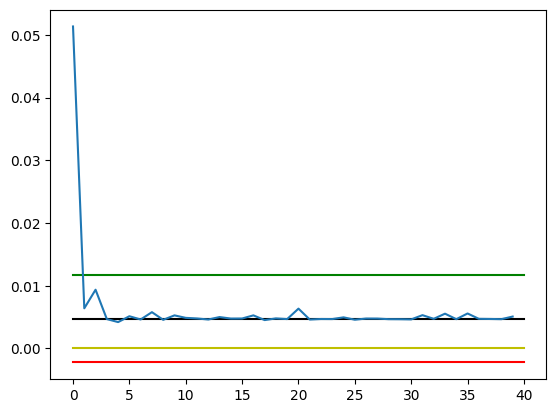

In [132]:
plt.plot([0, 40], [median_vec[1], median_vec[1]],'k')
plt.plot([0, 40], [median_vec[0], median_vec[0]],'r')
plt.plot([0, 40], [median_vec[2], median_vec[2]],'g')

plt.plot([0, 40], [0, 0],'y')

plt.plot(synced_time_vector[0:40] - behavior_time_vector[0:40])


In [133]:
trial_plot = trial_fix
samp_before = 100
samp_after = 160
if trial_plot == 0:
    last_iter_trial0 = iteration_dict['iter_start_idx'][trial_plot][0]-np.int64(samp_before)
else:
    last_iter_trial0 = iteration_dict['iter_start_idx'][trial_plot-1][-1]-np.int64(samp_before)
first_iter_trial1 = iteration_dict['iter_start_idx'][trial_plot][0]+np.int64(samp_after)
second_iter_trial1 = iteration_dict['iter_start_idx'][trial_plot][1]

samp_diff = iteration_dict['iter_start_idx'][trial_plot][0] - iteration_dict['iter_start_idx'][trial_plot-1][-1]
print('last_iter_trial0', last_iter_trial0)
print('first_iter_trial1', first_iter_trial1)

last_iter_trial0 4929436
first_iter_trial1 4930134


384
samples_after_second_pulse 32
224
new_iteration_channel 2
(17989515,)
time from niDAQ 9.404082055883672
time behavior [8.457346]
samples nidaq 47021
iter nidaq (922,)
iter_virmen (922, 1)


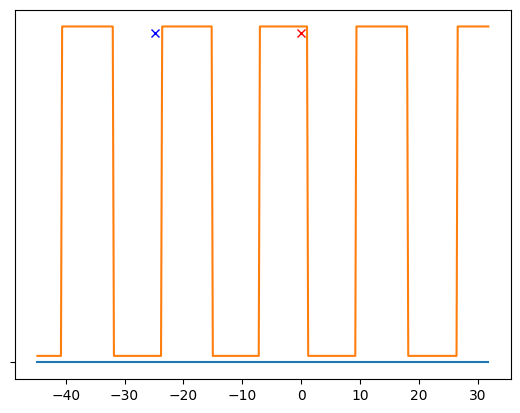

In [134]:

mode_plot = 'iters_here'
start_iter = 660
end_iter = 663


sample_start =(iteration_dict['iter_start_idx'][trial_plot][start_iter]-np.int64(samp_before))
sample_end = (iteration_dict['iter_start_idx'][trial_plot][end_iter]+np.int64(samp_after))

if mode_plot == 'iters_here':
    iter_sample = digital_array[new_trial_channel,sample_start:sample_end]
else:    
    iter_sample = digital_array[new_trial_channel,last_iter_trial0:first_iter_trial1]

time_vector = np.linspace(start=0, stop=iter_sample.shape[0]-1,num=iter_sample.shape[0])
time_vector = (time_vector*1000/nidq_sampling_rate)
time_vector -=  ((iter_sample.shape[0]-samp_after)*1000)/nidq_sampling_rate

time_last_trial = time_vector[0] +(samp_before*1000)/nidq_sampling_rate



print(iter_sample.shape[0])
samples_after_second_pulse = (second_iter_trial1-(first_iter_trial1-samp_after))
print('samples_after_second_pulse', samples_after_second_pulse)
print(iter_sample.shape[0]-samp_after)

idx_time_zero = np.where((time_vector >= 0))
idx_time_zero = idx_time_zero[0]
idx_time_zero = idx_time_zero[0]


print('new_iteration_channel', new_iteration_channel)
print(digital_array[new_iteration_channel,:].shape)

plt.plot(time_vector,iter_sample)
if mode_plot == 'iters_here':
    plt.plot(time_vector,digital_array[new_iteration_channel,sample_start:sample_end]+0.02)
else:    
    plt.plot(time_vector,digital_array[new_iteration_channel,last_iter_trial0:first_iter_trial1]+0.02)
plt.plot(0,1,"rx",'')
if mode_plot != 'iters_here':
    if (idx_time_zero+samples_after_second_pulse) < time_vector.shape[0]:
        plt.plot(time_vector[idx_time_zero+samples_after_second_pulse],1,"gx")
plt.plot(time_last_trial,1,"bx",)

iter_nidaq = (iteration_dict['iter_start_idx'][trial_plot][-1]-iteration_dict['iter_start_idx'][trial_plot][0])
time = iter_nidaq/nidq_sampling_rate
iter_virmen = time*120

print('time from niDAQ', time)
print('time behavior', behavior_time[trial_plot][-1])

print('samples nidaq', iter_nidaq)
print('iter nidaq', iteration_dict['iter_start_idx'][trial_plot].shape)
print('iter_virmen',behavior_time[trial_plot].shape)

#plt.xlim([-20, 20])

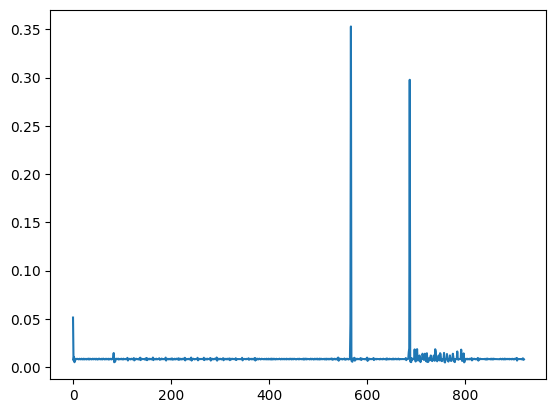

In [135]:
plt.plot(np.diff(behavior_time[trial_plot].flatten()))

Text(0.5, 1.0, 'Before & After applying (fix_shifted_sync_vector)')

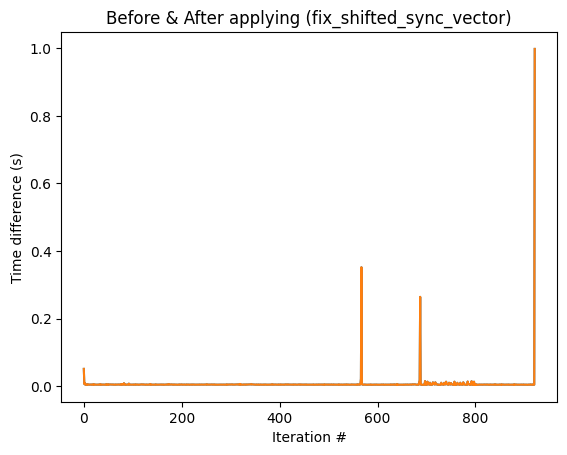

In [136]:
synced_time_vector3,_ = ephys_fix_sync_code.fix_shifted_sync_vector(synced_time_vector2, behavior_time_vector, shift_vec)

plt.plot(synced_time_vector2 - behavior_time_vector[:synced_time_vector2.shape[0]])
plt.plot(synced_time_vector3 - behavior_time_vector[:synced_time_vector3.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (fix_shifted_sync_vector)')

#plt.ylim([-0.1,0.1])



Text(0.5, 1.0, 'Before & After applying (complete_last_part_sync_vec)')

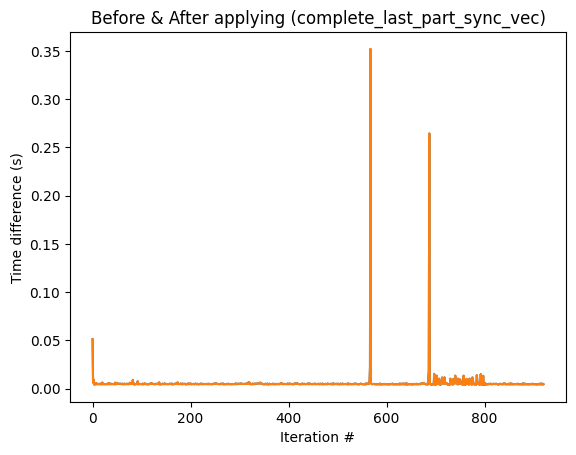

In [137]:
synced_time_vector4,_ =\
    ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector3, behavior_time_vector)

plt.plot(synced_time_vector3[:-1] - behavior_time_vector[:synced_time_vector3.shape[0]-1])
plt.plot(synced_time_vector4[:-1] - behavior_time_vector[:synced_time_vector4.shape[0]-1])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (complete_last_part_sync_vec)')

#plt.ylim([-9, 0.1])

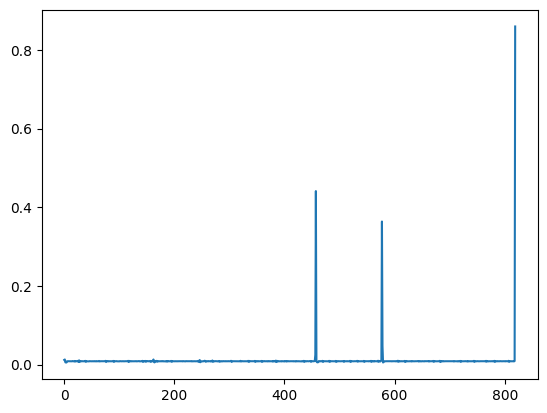

In [92]:
plt.plot(np.diff(synced_time_vector4))
#plt.plot(np.diff(behavior_time_vector))

Text(0.5, 1.0, 'Before & After applying (complete_last_part_sync_vec)')

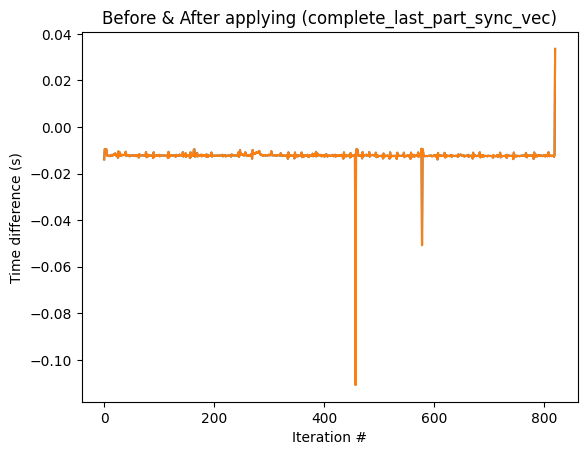

In [93]:
synced_time_vector4,_ =\
    ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector3, behavior_time_vector)

plt.plot(synced_time_vector - behavior_time_vector[:synced_time_vector.shape[0]])
plt.plot(synced_time_vector4 - behavior_time_vector[:synced_time_vector4.shape[0]])


plt.xlabel('Iteration #')
plt.ylabel('Time difference (s)')
plt.title('Before & After applying (complete_last_part_sync_vec)')

#plt.ylim([-0.4, 5])

In [94]:
print('synced_time_vector3', synced_time_vector3.shape[0])

synced_time_vector3 821


In [95]:
print('behavior_time_vector', behavior_time_vector.shape[0])

behavior_time_vector 821
